<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Utility Functions</a></span></li><li><span><a href="#Experiment-1:-Can-we-find-the-true-GIA-model-when-GMSL-is-not-equal-to-Wael?" data-toc-modified-id="Experiment-1:-Can-we-find-the-true-GIA-model-when-GMSL-is-not-equal-to-Wael?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Experiment 1: Can we find the true GIA model when GMSL is not equal to Wael?</a></span><ul class="toc-item"><li><span><a href="#True-GIA-Model:" data-toc-modified-id="True-GIA-Model:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>True GIA Model:</a></span></li><li><span><a href="#Look-at-TRUE-GIA-model-output" data-toc-modified-id="Look-at-TRUE-GIA-model-output-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Look at TRUE GIA model output</a></span></li><li><span><a href="#Generate-'data'-from-true-GIA-model-(varying-age-and-location)." data-toc-modified-id="Generate-'data'-from-true-GIA-model-(varying-age-and-location).-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Generate 'data' from true GIA model (varying age and location).</a></span></li><li><span><a href="#Infer-GMSL" data-toc-modified-id="Infer-GMSL-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Infer GMSL</a></span></li><li><span><a href="#Calculate-relative-model-weights-for-all-inferences" data-toc-modified-id="Calculate-relative-model-weights-for-all-inferences-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Calculate relative model weights for all inferences</a></span><ul class="toc-item"><li><span><a href="#Add-GIA-model-parameters-and-identify-TRUE-model-in-Dataframe" data-toc-modified-id="Add-GIA-model-parameters-and-identify-TRUE-model-in-Dataframe-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>Add GIA model parameters and identify TRUE model in Dataframe</a></span></li><li><span><a href="#Save-dataframe-as-csv" data-toc-modified-id="Save-dataframe-as-csv-3.5.2"><span class="toc-item-num">3.5.2&nbsp;&nbsp;</span>Save dataframe as csv</a></span></li></ul></li><li><span><a href="#Summary-figure-showing-model-weightings-for-all-216-GIA-models" data-toc-modified-id="Summary-figure-showing-model-weightings-for-all-216-GIA-models-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Summary figure showing model weightings for all 216 GIA models</a></span></li><li><span><a href="#Use-the-weightings-to-make-a-combined-GMSL-inference" data-toc-modified-id="Use-the-weightings-to-make-a-combined-GMSL-inference-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Use the weightings to make a combined GMSL inference</a></span><ul class="toc-item"><li><span><a href="#Generate-predictions-from-gaussian-process-posterior-for-top-models" data-toc-modified-id="Generate-predictions-from-gaussian-process-posterior-for-top-models-3.7.1"><span class="toc-item-num">3.7.1&nbsp;&nbsp;</span>Generate predictions from gaussian process posterior for top models</a></span></li><li><span><a href="#Generate-a-weighted-prediction" data-toc-modified-id="Generate-a-weighted-prediction-3.7.2"><span class="toc-item-num">3.7.2&nbsp;&nbsp;</span>Generate a weighted prediction</a></span></li><li><span><a href="#Plot-predictions-from-the-TRUE-GIA-model-and-the-weighted-metamodel" data-toc-modified-id="Plot-predictions-from-the-TRUE-GIA-model-and-the-weighted-metamodel-3.7.3"><span class="toc-item-num">3.7.3&nbsp;&nbsp;</span>Plot predictions from the TRUE GIA model and the weighted metamodel</a></span></li></ul></li></ul></li><li><span><a href="#Experiment-2:-Can-we-find-the-true-GIA-model-when-GMSL-is-not-equal-to-Wael?" data-toc-modified-id="Experiment-2:-Can-we-find-the-true-GIA-model-when-GMSL-is-not-equal-to-Wael?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Experiment 2: Can we find the true GIA model when GMSL is not equal to Wael?</a></span><ul class="toc-item"><li><span><a href="#True-GIA-Model:" data-toc-modified-id="True-GIA-Model:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>True GIA Model:</a></span></li><li><span><a href="#Look-at-TRUE-GIA-model-output" data-toc-modified-id="Look-at-TRUE-GIA-model-output-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Look at TRUE GIA model output</a></span></li><li><span><a href="#Generate-'data'-from-true-GIA-model-(varying-age-and-location)." data-toc-modified-id="Generate-'data'-from-true-GIA-model-(varying-age-and-location).-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Generate 'data' from true GIA model (varying age and location).</a></span></li><li><span><a href="#Infer-GMSL" data-toc-modified-id="Infer-GMSL-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Infer GMSL</a></span></li><li><span><a href="#Calculate-relative-model-weights-for-all-inferences" data-toc-modified-id="Calculate-relative-model-weights-for-all-inferences-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Calculate relative model weights for all inferences</a></span><ul class="toc-item"><li><span><a href="#Add-GIA-model-parameters-and-identify-TRUE-model-in-Dataframe" data-toc-modified-id="Add-GIA-model-parameters-and-identify-TRUE-model-in-Dataframe-4.5.1"><span class="toc-item-num">4.5.1&nbsp;&nbsp;</span>Add GIA model parameters and identify TRUE model in Dataframe</a></span></li><li><span><a href="#Save-dataframe-as-csv" data-toc-modified-id="Save-dataframe-as-csv-4.5.2"><span class="toc-item-num">4.5.2&nbsp;&nbsp;</span>Save dataframe as csv</a></span></li></ul></li><li><span><a href="#Summary-figure-showing-model-weightings-for-all-216-GIA-models" data-toc-modified-id="Summary-figure-showing-model-weightings-for-all-216-GIA-models-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Summary figure showing model weightings for all 216 GIA models</a></span></li><li><span><a href="#Use-the-weightings-to-make-a-combined-GMSL-inference" data-toc-modified-id="Use-the-weightings-to-make-a-combined-GMSL-inference-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Use the weightings to make a combined GMSL inference</a></span><ul class="toc-item"><li><span><a href="#Generate-predictions-from-gaussian-process-posterior-for-top-models" data-toc-modified-id="Generate-predictions-from-gaussian-process-posterior-for-top-models-4.7.1"><span class="toc-item-num">4.7.1&nbsp;&nbsp;</span>Generate predictions from gaussian process posterior for top models</a></span></li><li><span><a href="#Generate-a-weighted-prediction" data-toc-modified-id="Generate-a-weighted-prediction-4.7.2"><span class="toc-item-num">4.7.2&nbsp;&nbsp;</span>Generate a weighted prediction</a></span></li><li><span><a href="#Plot-predictions-from-the-TRUE-GIA-model-and-the-weighted-metamodel" data-toc-modified-id="Plot-predictions-from-the-TRUE-GIA-model-and-the-weighted-metamodel-4.7.3"><span class="toc-item-num">4.7.3&nbsp;&nbsp;</span>Plot predictions from the TRUE GIA model and the weighted metamodel</a></span></li></ul></li></ul></li><li><span><a href="#Experiment-3:-Can-we-find-the-true-GIA-model-using-data-locations,-age,-and-small-age-errors?" data-toc-modified-id="Experiment-3:-Can-we-find-the-true-GIA-model-using-data-locations,-age,-and-small-age-errors?-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Experiment 3: Can we find the true GIA model using data locations, age, and small age errors?</a></span><ul class="toc-item"><li><span><a href="#True-GIA-Model:" data-toc-modified-id="True-GIA-Model:-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>True GIA Model:</a></span></li><li><span><a href="#Look-at-TRUE-GIA-model-output" data-toc-modified-id="Look-at-TRUE-GIA-model-output-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Look at TRUE GIA model output</a></span></li><li><span><a href="#Generate-'data'-from-true-GIA-model-(varying-age-and-location)." data-toc-modified-id="Generate-'data'-from-true-GIA-model-(varying-age-and-location).-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Generate 'data' from true GIA model (varying age and location).</a></span></li><li><span><a href="#Infer-GMSL" data-toc-modified-id="Infer-GMSL-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Infer GMSL</a></span></li><li><span><a href="#Calculate-relative-model-weights-for-all-inferences" data-toc-modified-id="Calculate-relative-model-weights-for-all-inferences-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Calculate relative model weights for all inferences</a></span><ul class="toc-item"><li><span><a href="#Add-GIA-model-parameters-and-identify-TRUE-model-in-Dataframe" data-toc-modified-id="Add-GIA-model-parameters-and-identify-TRUE-model-in-Dataframe-5.5.1"><span class="toc-item-num">5.5.1&nbsp;&nbsp;</span>Add GIA model parameters and identify TRUE model in Dataframe</a></span></li><li><span><a href="#Save-dataframe-as-csv" data-toc-modified-id="Save-dataframe-as-csv-5.5.2"><span class="toc-item-num">5.5.2&nbsp;&nbsp;</span>Save dataframe as csv</a></span></li></ul></li><li><span><a href="#Summary-figure-showing-model-weightings-for-all-216-GIA-models" data-toc-modified-id="Summary-figure-showing-model-weightings-for-all-216-GIA-models-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Summary figure showing model weightings for all 216 GIA models</a></span></li><li><span><a href="#Use-the-weightings-to-make-a-combined-GMSL-inference" data-toc-modified-id="Use-the-weightings-to-make-a-combined-GMSL-inference-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>Use the weightings to make a combined GMSL inference</a></span><ul class="toc-item"><li><span><a href="#Generate-predictions-from-gaussian-process-posterior-for-top-models" data-toc-modified-id="Generate-predictions-from-gaussian-process-posterior-for-top-models-5.7.1"><span class="toc-item-num">5.7.1&nbsp;&nbsp;</span>Generate predictions from gaussian process posterior for top models</a></span></li><li><span><a href="#Generate-a-weighted-prediction" data-toc-modified-id="Generate-a-weighted-prediction-5.7.2"><span class="toc-item-num">5.7.2&nbsp;&nbsp;</span>Generate a weighted prediction</a></span></li><li><span><a href="#Plot-predictions-from-the-TRUE-GIA-model-and-the-weighted-metamodel" data-toc-modified-id="Plot-predictions-from-the-TRUE-GIA-model-and-the-weighted-metamodel-5.7.3"><span class="toc-item-num">5.7.3&nbsp;&nbsp;</span>Plot predictions from the TRUE GIA model and the weighted metamodel</a></span></li></ul></li></ul></li></ul></div>

# Imports

In [2]:
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from scipy import ndimage
import arviz as az
import pandas as pd
from scipy.io import loadmat

%matplotlib inline
import seaborn as sns
from PIL import Image

sns.set_style("ticks")
sns.set_context("talk")
import pymc3 as pm

from pathlib import Path

PROJECT_ROOT = Path.cwd().parents[0]
model_dir = PROJECT_ROOT / "model_outputs/"
data_dir = PROJECT_ROOT / "data/"
import warnings

warnings.filterwarnings("ignore")
from IPython.display import clear_output

import theano.tensor as tt
from theano import shared
from pymc3.distributions.dist_math import SplineWrapper



# Utility Functions 
modified from bahamas-gia -- eventually port to utils.py file

In [108]:
def weighted_trace(pred_list, weights):
    new_weights = np.repeat(weights, pred_list[0]["f_pred"].shape[0], axis=0)
    new_weights = new_weights.astype(float)
    new_weights = new_weights / np.sum(new_weights)
    test = [p["f_pred"] for p in pred_list]
    C = np.random.choice(np.arange(np.vstack(test).shape[0]), 10000, p=new_weights)
    weighted_trace = np.vstack(test)[C, :]
    
    return weighted_trace


def inference_model(data, z_functions):
    with pm.Model() as model:
        age_sd = pm.Normal("age_sd", 0, 1, shape=(data["lat"].size))
        age = pm.Deterministic(
            "age", shared(data["age"]) + age_sd * shared(data["age_uncertainty"])
        )  # reshaped to improve Hamiltonian Monte Carlo
        matern_ls = pm.HalfCauchy("matern_ls", 1)
        matern_var = pm.HalfCauchy("matern_var", 1)
        m_gmsl = pm.Normal("m_gmsl", 0, 20)
        mean_fun = pm.gp.mean.Constant(m_gmsl)
        cov = matern_var * pm.gp.cov.Matern52(1, matern_ls)
        gp = pm.gp.Marginal(mean_func=mean_fun, cov_func=cov)
        GIA = tt.zeros(data["lat"].size, dtype="float64")
        for i in range(data["lat"].size):
            GIA = tt.set_subtensor(GIA[i], SplineWrapper(z_functions[i])(age[i]))
        gia_collect = pm.Deterministic(
            "GIA", GIA
        )  # samples of GIA model RSL (includes Wael)
        
        sigma = pm.HalfCauchy("sigma", 1)
        elev_u = pm.Normal('observed_elevation_u',0,data["elevation_uncertainty"],shape=(N))
        gmsl_inference = gp.marginal_likelihood(
            "gmsl",
            X=age[:, np.newaxis],
            y=data["elevation"] - GIA.flatten() + elev_u,
            shape=((N),),
            noise=sigma,
        )  # GMSL deviation from Wael
        trace = pm.sample(init="adapt_full", progressbar=True, cores=4)
        az_trace = az.convert_to_inference_data(trace)
    return az_trace, trace, model, gp

def interpolation_functions(LAT, LON, GIA_MODEL, ESL, ESL_AGE):
    island_Zs = [
        [lookup_z(lat, lon, m, model_dims) for lat, lon in zip(LAT, LON)]
        for m in GIA_MODEL
    ]

    island_Zs = np.array(island_Zs)

#     ESL[(ESL_AGE >= LIG_END) & (ESL_AGE <= LIG_START)] = 0  # remove GIA splice

    Zfuns = []
    for k in range(island_Zs.shape[1]):
        RSL = np.copy(ESL)
        gia_function = interp1d(
            np.arange(115, 131), island_Zs[:, k]
        )  # age resolution different than gia models
        RSL[(ESL_AGE >= 115) & (ESL_AGE <= 130)] = gia_function(
            ESL_AGE[(ESL_AGE >= 115) & (ESL_AGE <= 130)]
        )  # splice in GIA

        Zfuns.append(
            UnivariateSpline(ESL_AGE, RSL, k=1, ext=3, s=0)
        )  ## 3 returns boundary value at extrapolation

    return Zfuns

def model_import():
    """
    Imports all GIA models from model_outputs/get_GIA.
    Parameters
    ----------
    Returns
    -------
    models: list containing each GIA model
    model_names: name of each model
    litho: lithosphere thickness for each model
    lower: the lower mantle viscosity of each model
    upper: the upper mantle viscosity of each model
    model_dims: The real word lat/lon dimensions of the model. [left, right, top, bottom]
    """
    import pandas as pd
    from scipy.interpolate import interp1d


    lats = pd.read_csv(model_dir / "lats", delimiter=",", header=None)
    lons = pd.read_csv(model_dir / "lons", delimiter=",", header=None)
    directory = model_dir / "get_GIA/"
    age = np.arange(115, 131, 1)

    extent = [0, 1, 0, 1]
    model_dims = [
        np.min(lons.values),
        np.max(lons.values),
        np.min(lats.values),
        np.max(lats.values),
    ]
    import os
    import pandas as pd

    files = np.sort(os.listdir(directory))
    files = [f for f in files if f[0] != "."]  # ignores .ds_store from mac osx dir

    model_names = []
    for f in files:
        model_names.append(
            f.split("_")[0]
            + "_"
            + f.split("_")[1]
            + "_"
            + f.split("_")[2]
            + "_"
            + f.split("_")[3]
        )

    num_of_models = np.unique(model_names).size
    model_names = np.unique(model_names)

    
    models = []

    for i in range(0, len(files), int(len(files) / model_names.size)):
        model = []
        for k in range(int(len(files) / model_names.size)):
            model.append(
                pd.read_csv(
                    str(directory) + "/" + files[i + k], delimiter=",", header=None
                )
            )
        models.append(model)
        
    
    #HACKY PATCH as GIA MODEL IS FULL EARTH NOT lat/lon from lat/lon files:
    lon_to_id = interp1d([-180,180],[0,models[0][0].shape[1]])
    lat_to_id = interp1d([-90,90],[0,models[0][0].shape[0]])
    id_lon=lon_to_id(model_dims[:2]).astype(int)
    id_lat=lat_to_id(model_dims[2:]).astype(int)
    
    for m in range(len(models)):
        for k in range(len(models[m])):
            models[m][k] = models[m][k].values[slice(id_lat[0],id_lat[1],1),slice(id_lon[0],id_lon[1],1)]


    import re

    litho = []
    upper = []
    lower = []
    for f in files[0 : -1 : int(len(files) / model_names.size)]:
        litho.append(float(f.split("_")[0][6:8]))
        upper.append(float("0." + (f.split("_")[0][10])) * 10 ** 21)
        lower.append(float(f.split("_")[0][11:]) * 10 ** 21)
    litho = np.array(litho).astype(int)
    lower = np.array(lower).astype(float)
    upper = np.array(upper).astype(float)

    return models, model_names, litho, lower, upper, model_dims


def lookup_z(lat, lon, model, model_dims):
    """
    Returns the RSL prediction at a specific lat, lon, on a specific GIA model timeslice.
    Parameters
    ----------
    lat: Latitude value
    lon: Longitude value
    model: A 2d matrix from a GIA model output representing a single timeslice.
    model_dims: The real word lat/lon dimensions of the model. [left, right, top, bottom]
    Returns
    -------
    The model RSL prediction nearest the lat, lon pair.
    """
    lat_len = model.shape[0]
    lon_len = model.shape[1]
    lon_list = np.linspace(model_dims[0], model_dims[1], lon_len)
    lat_list = np.linspace(model_dims[3], model_dims[2], lat_len)
    lon_id = np.argmin(
        np.abs(np.linspace(model_dims[0], model_dims[1], lon_len) - (lon))
    )
    lat_id = np.argmin(
        np.abs(np.linspace(model_dims[3], model_dims[2], lat_len) - (lat))
    )
    return model[lat_id, lon_id]

Load GIA Models:

In [4]:
models, model_names, litho, lower, upper, model_dims = model_import()

In [5]:
ESL_mat = loadmat(data_dir / "processed/ESL.mat")
Wael = ESL_mat["Wael_S"].ravel()
Wael_T = ESL_mat["Wael_T"].ravel()
Age_ESL = ESL_mat["age_com"].ravel()

LIG_START = 128
LIG_END = 117

Load land area mask:

In [6]:
im = Image.open(data_dir / "images/land_mask.tif")
imarray = np.array(im)
imarray_ext = [-180.00000000000003, 180.00000000000003, -85.05112880000001, 83.6664731]
landzoom = ndimage.zoom(imarray, 2, order=3)
my_grey = cm.Greys_r
my_grey.set_under("k", alpha=0)

# Experiment 1: Can we find the true GIA model when GMSL is not equal to Wael?
* Select a GIA model to be TRUE
* Generate 'data' from that TRUE GIA model
* Add sinusoidal GMSL to the data
* Plug each GIA model into our existing GMSL inference framework
* Compare the weights or information criteria of each model (does the TRUE model win?)
* Use model weightings to make a GMSL inference with ALL models

## True GIA Model:
Select one of the real GIA models as 'True'

In [8]:
np.random.seed(42)

N = len(model_names)
true_choice = np.random.choice(N, 1)[0]
true_model = models[true_choice]
print("Model " + str(model_names[true_choice]) + " selected as TRUE model.")

np.random.seed()

Model output71Cp37_Colleoni_Wael_S selected as TRUE model.


In [9]:
zoomlevel = 4
i = 13  # age slice
early_LIG = ndimage.zoom(true_model[i], zoomlevel, order=3)
i = 3  # age slice
late_LIG = ndimage.zoom(true_model[i], zoomlevel, order=3)

## Look at TRUE GIA model output

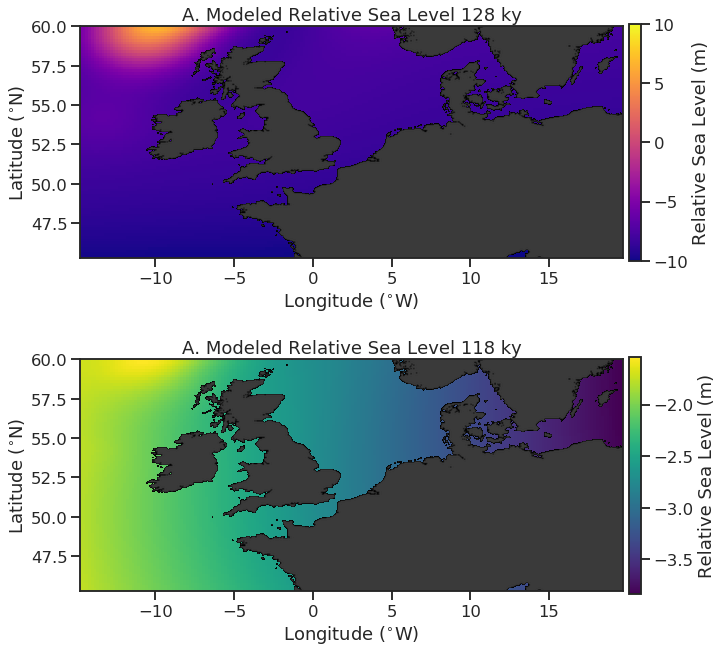

In [10]:
fig = plt.figure(figsize=(10, 9))
plt.subplot(2, 1, 1)
shrink = 0.9
plt.imshow(
    early_LIG,
    interpolation="nearest",
    cmap="plasma",
    extent=model_dims,
    vmin=-10,vmax=10
)
plt.colorbar(
    shrink=shrink,
    pad=0.01,
    label="Relative Sea Level (m)",
)
my_grey = cm.Greys_r
my_grey.set_under("k", alpha=0)
plt.imshow(
    landzoom,
    interpolation="gaussian",
    cmap=my_grey,
    vmin=0.1,
    vmax=5,
    extent=imarray_ext,
)
plt.gca().set_title("A. Modeled Relative Sea Level 128 ky")
plt.gca().grid(False)
plt.gca().set_xlim([model_dims[0], model_dims[1]])
plt.gca().set_ylim([model_dims[2], model_dims[3]])
plt.gca().set_ylabel("Latitude ($^{\circ}$N)")
plt.gca().set_xlabel("Longitude ($^{\circ}$W)")
plt.subplot(2, 1, 2)
plt.imshow(
    late_LIG,
    interpolation="nearest",
    cmap="viridis",
    extent=model_dims,
)
plt.colorbar(
    shrink=shrink,
    pad=0.01,
    label="Relative Sea Level (m)",)
my_grey = cm.Greys_r
my_grey.set_under("k", alpha=0)
plt.imshow(
    landzoom,
    interpolation="gaussian",
    cmap=my_grey,
    vmin=0.1,
    vmax=5,
    extent=imarray_ext,
)
plt.gca().set_title("A. Modeled Relative Sea Level 118 ky")
plt.gca().grid(False)
plt.gca().set_xlim([model_dims[0], model_dims[1]])
plt.gca().set_ylim([model_dims[2], model_dims[3]])
plt.gca().set_ylabel("Latitude ($^{\circ}$N)")
plt.gca().set_xlabel("Longitude ($^{\circ}$W)")
fig.tight_layout(pad=0, w_pad=-2, h_pad=1)


Self reminder for interpretation: subsidence = bottom panel minus the top panel. For example, the orth west corner is -2 at 118 ky and +10 at 128 ky. This area has subsided -12 meters (or uplifted 12 meters). 

## Generate 'data' from true GIA model (varying age and location).

In [12]:
data_number = 17 ## datapoints to generate

In [13]:
data = {}
data["lon"] = np.random.uniform(model_dims[0], model_dims[1], data_number)
data["lat"] = np.random.uniform(model_dims[2], model_dims[3], data_number)
data["age"] = np.random.choice(np.arange(115, 130), data_number, replace=True)
data["age_uncertainty"] = np.ones(data_number) * 0.5
A = np.arange(115, 131, 1)

## no interpolation of age for now, but easy to add (ie ages are all intervals of 1 ky)
Es = []
for i in range(data["lat"].size):
    t_slice = np.where(A == data["age"][i])[0][0]
    Es.append(lookup_z(data["lat"][i], data["lon"][i], true_model[t_slice], model_dims))
data["rsl"] = np.array(Es)
data["elevation_uncertainty"] = np.ones(data_number) * 0.5

Make GMSL during LIG greater than zero and changing:

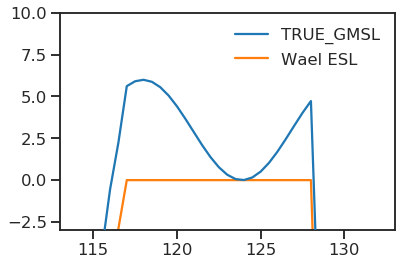

In [15]:
sns.set_context('talk')
LIG = (Age_ESL>=115) & (Age_ESL<=130) 

k=true_choice
GIA_MODEL = models[k]
if '_S' in model_names[k]:
    ESL_CURVE = Wael
if '_T' in model_names[k]:
    ESL_CURVE = Wael_T
    
synth_gmsl = np.copy(ESL_CURVE)
xt=Age_ESL[LIG]-Age_ESL[LIG].min()
synth_gmsl[LIG]=ESL_CURVE[LIG]+3*np.sin(xt/(.6*np.pi))+3
plt.plot(Age_ESL,synth_gmsl,label='TRUE_GMSL',zorder=3)
plt.plot(Age_ESL,ESL_CURVE,label='Wael ESL')
plt.gca().set_xlim([113,133])
plt.gca().set_ylim([-3,10])
plt.legend(loc='best',frameon=False)

In [16]:
synth_gmsl_fun=interp1d(Age_ESL,synth_gmsl)
ESL_CURVE_fun=interp1d(Age_ESL,ESL_CURVE)
synth_gmsl_fun(Age_ESL)

## add true gmsl to RSL model
data['elevation']=np.copy(data['rsl'])
for i in range(data["lat"].size):
    data["elevation"][i] += synth_gmsl_fun(data['age'][i])-ESL_CURVE_fun(data['age'][i])

Look at data:

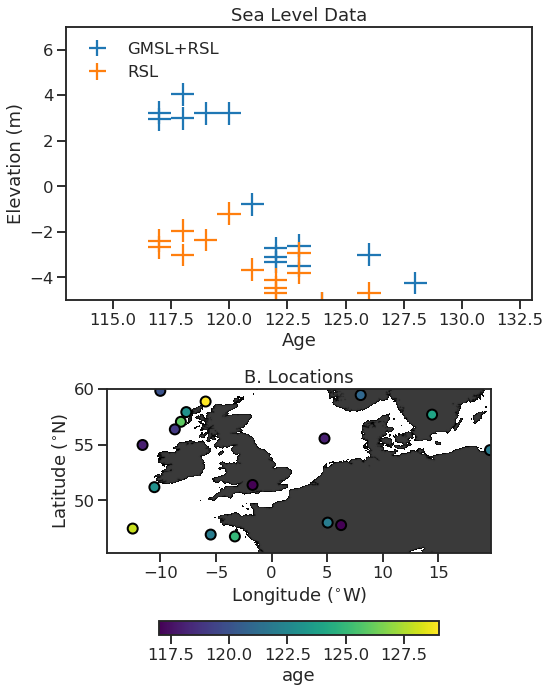

In [17]:
sns.set_context('talk')
fig=plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.errorbar(
    data["age"],
    data["elevation"],
    xerr=data["age_uncertainty"],
    yerr=data["elevation_uncertainty"],
    linestyle="none",label='GMSL+RSL'
)
plt.errorbar(
    data["age"],
    data["rsl"],
    xerr=data["age_uncertainty"],
    yerr=data["elevation_uncertainty"],
    linestyle="none",label='RSL'
)

plt.legend(loc='upper left',frameon=False)



plt.gca().set_xlabel('Age')
plt.gca().set_ylabel('Elevation (m)')
_=plt.gca().set_title('Sea Level Data')
plt.gca().set_xlim([113,133])
plt.gca().set_ylim([-5,7])

plt.subplot(2,1,2)

plt.imshow(
    landzoom,
    interpolation="gaussian",
    cmap=my_grey,
    vmin=0.1,
    vmax=5,
    extent=imarray_ext,
)

plt.scatter(data['lon'],data['lat'],c=data['age'],cmap='viridis',s=100,edgecolor='k',lw=2)
plt.colorbar(label='age',shrink=.6,pad=0.25, orientation="horizontal")
plt.gca().set_title("B. Locations")
plt.gca().grid(False)
plt.gca().set_xlim([model_dims[0], model_dims[1]])
plt.gca().set_ylim([model_dims[2], model_dims[3]])
plt.gca().set_ylabel("Latitude ($^{\circ}$N)")
plt.gca().set_xlabel("Longitude ($^{\circ}$W)")
fig.tight_layout()


## Infer GMSL

In [19]:
N = data["elevation"].size
comparison = {}
stats_models = {}
gps = {}

for k in range(len(model_names)):
    clear_output(wait=True)
    print("running simulation number " + str(k + 1) + " of " + str(len(models)))
    print("running model: " + model_names[k])
    GIA_MODEL = models[k]
    if "_S" in model_names[k]:
        ESL_CURVE = np.copy(Wael)
    if "_T" in model_names[k]:
        ESL_CURVE = np.copy(Wael_T)

    z_functions = interpolation_functions(
        data["lat"], data["lon"], GIA_MODEL, ESL_CURVE, Age_ESL
    )
    az_trace, trace, model, gp = inference_model(data, z_functions)
    comparison[model_names[k]] = az_trace
    stats_models[model_names[k]] = model
    gps[model_names[k]] = gp
     

running simulation number 216 of 216
running model: output96Cp57_Lambeck_Wael_T


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_gmsl, matern_var, matern_ls, age_sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


## Calculate relative model weights for all inferences 
We use leave-one-out (loo) cross validation with an Akaike-type weighting. The weights are stabilized using a Bayesian bootstrap. https://arviz-devs.github.io/arviz/generated/arviz.compare.html

In [20]:
comp = pm.compare(comparison, ic="loo", b_samples=100000) #overkill on samples, but it is fast enough

### Add GIA model parameters and identify TRUE model in Dataframe

In [22]:
compare_model_names = comp.index.values
model_params_df = {}
for i in range(len(compare_model_names)):
    md_id = np.where(model_names == compare_model_names[i])[0][0]
    ice_history = compare_model_names[i].split("_")[1]
    esl_curve = compare_model_names[i].split("_")[2]
    deglacial_rate = compare_model_names[i].split("_")[3]
    model_params_df[compare_model_names[i]] = [
        lower[md_id],
        upper[md_id],
        litho[md_id],
        ice_history,
        esl_curve,
        deglacial_rate,
    ]

df2 = pd.DataFrame.from_dict(
    model_params_df,
    orient="index",
    columns=["LMV", "UMV", "lithosphere", "ice_history", "esl_curve", "deglacial_rate"],
)

comp3 = comp.join(df2)

identify = {}
for i in range(len(model_names)):
    if i == true_choice:
        identify[model_names[i]] = True
    else:
        identify[model_names[i]] = False

df3 = pd.DataFrame.from_dict(identify, orient="index", columns=["true_model"],)

comp3 = comp.join(df2).join(df3)


### Save dataframe as csv

In [55]:
comp3.to_csv('true_model_experiment1.csv')

## Summary figure showing model weightings for all 216 GIA models

In [24]:
# one subplot for each experiment
experiments = [
    ["Lambeck", "S", 96],
    ["Colleoni", "S", 96],
    ["ICE6G", "S", 96],
    ["Lambeck", "T", 96],
    ["Colleoni", "T", 96],
    ["ICE6G", "T", 96],
    ["Lambeck", "S", 71],
    ["Colleoni", "S", 71],
    ["ICE6G", "S", 71],
    ["Lambeck", "T", 71],
    ["Colleoni", "T", 71],
    ["ICE6G", "T", 71],
    ["Lambeck", "S", 48],
    ["Colleoni", "S", 48],
    ["ICE6G", "S", 48],
    ["Lambeck", "T", 48],
    ["Colleoni", "T", 48],
    ["ICE6G", "T", 48],
]

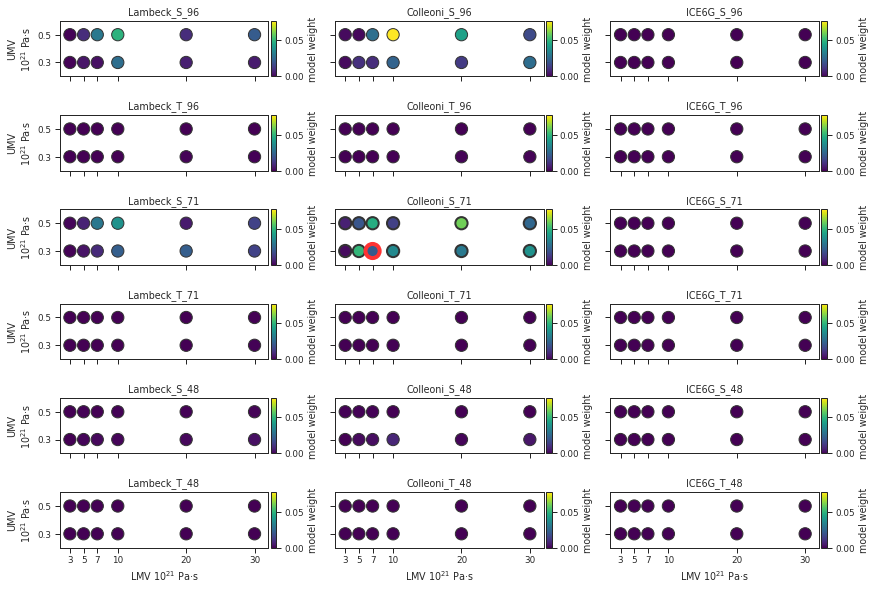

In [33]:
sns.set_context("paper")
fig = plt.figure(figsize=(12, 8))
for i in range(0, 18):
    experiment = experiments[i]
    plt.subplot(6, 3, 1 + i)
    filtered = comp3[
        (comp3.ice_history == experiment[0])
        & (comp3.deglacial_rate == experiment[1])
        & (comp3.lithosphere == experiment[2])
    ]
    if filtered["true_model"].unique().size == 1:
        plt.scatter(
            filtered["LMV"].values,
            filtered["UMV"] / 1e21,
            c=filtered["weight"],
            s=150,
            cmap="viridis",
            edgecolor=(0.2, 0.2, 0.2),
            lw=1,
            vmin=0,
            vmax=comp3["weight"].max(),
            zorder=2,
        )
    else:
        ec = np.dot(
            filtered["true_model"].values.astype(int)[:, np.newaxis],
            np.array([0.8, 0.0, 0.0])[np.newaxis, :],
        )
        ew = filtered["true_model"].values.astype(int) * 2
        s = filtered["true_model"].values.astype(int) * 50
        plt.scatter(
            filtered["LMV"].values,
            filtered["UMV"] / 1e21,
            c=filtered["weight"],
            s=150 + s,
            cmap="viridis",
            edgecolor=np.array([0.2, 0.2, 0.2]) + ec,
            lw=2 + ew,
            vmin=0,
            vmax=comp3["weight"].max(),
            zorder=2,
        )

    plt.colorbar(label="model weight", pad=.01, aspect=10)

    plt.gca().set_xticklabels((np.round(np.unique(lower), 0) / 1e21).astype(int))
    plt.gca().set_yticks(np.unique(upper) / 1e21)
    plt.gca().set_xticks(np.unique(lower))
    plt.gca().set_xlim(1.5e21, 32e21)
    plt.gca().set_ylim(0.2, 0.6)
    if i > 14:
        plt.gca().set_xlabel("LMV $10^{21}$ Pa·s")
    else:
        plt.gca().set_xticklabels([])
    if i % 3 == 0:
        plt.gca().set_ylabel("UMV\n$10^{21}$ Pa·s")
    else:
        plt.gca().set_yticklabels([])

    plt.minorticks_off()
    plt.gca().set_title(experiment[0] + "_" + experiment[1] + "_" + str(experiment[2]))


fig.tight_layout()
fig.tight_layout(pad=0, w_pad=1, h_pad=2)

Each circle represents a GIA model. The color of the circle is the probability that the observations were generated by the model relative to the probability that the observations were generated by any of the other models (the weightings sum to 1). The circle highlighted with a <span style='color:red;font-weight:bold'>RED</span> border is the model that was actually used to generate the data (the 'TRUE' GIA model). Remember that these weightings show similarities between GIA models at the lat/lon, the age of the samples, AND the prescribed GMSL.

## Use the weightings to make a combined GMSL inference
We will never know the 'true' GIA model, but we should include the uncertainty of all of the likely models in our prediction. The weightings offer guidance on how important each model should be in that final inference.

### Generate predictions from gaussian process posterior for top models

In [35]:
# all models with more than 1% weight
top_models = comp3[comp["weight"] > 0.01]["rank"].values
# new timespan to evaluate the gaussian process
X_new = np.linspace(110, 140, 200)[:, np.newaxis]

pred_traces = []  # list to collect all of the predictions
for i in top_models:
    clear_output(wait=True)
    print("sampling model " + str(i + 1) + " of " + str(len(top_models)))
    to_plot = comp3[comp3["rank"] == i].index[0]  # model name (str)
    model = stats_models[to_plot]  # (str) names are used as keys
    gp = gps[to_plot]
    az_trace = comparison[to_plot]

    with model:  # pymc3 model context
        # add conditional to each model (comment out if running this cell twice)
        f_pred = gp.conditional("f_pred", X_new)

    X_new = np.linspace(110, 140, 200)[:, np.newaxis]
    pred_samples = pm.sample_posterior_predictive(
        az_trace.posterior,  # if using pymc3 trace remove '.posterior'
        model=model,
        vars=[f_pred],
        samples=1000,
    )
    pred_traces.append(pred_samples)

sampling model 28 of 28


### Generate a weighted prediction

In [49]:
weights = comp['weight'].values[top_models.astype(int)]
weighted_gmsl_trace = weighted_trace(pred_traces, weights)

### Plot predictions from the TRUE GIA model and the weighted metamodel

Text(0.5, 1.0, 'EU GMSL Inference Experiment')

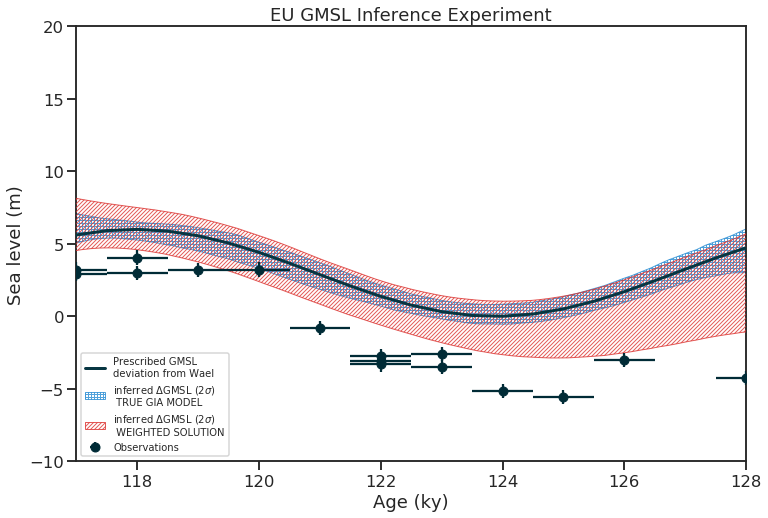

In [54]:
fig = plt.figure(figsize=(12, 8))
sns.set_context("talk")

plt.plot(
    Age_ESL,
    synth_gmsl,
    label="Prescribed GMSL\ndeviation from Wael",
    zorder=3,
    lw=3,
    color="#073642",
)



plt.errorbar(
    data["age"],
    data["elevation"],
    xerr=data["age_uncertainty"],
    yerr=data["elevation_uncertainty"],
    marker="o",
    linestyle="none",
    label="Observations",
    color="#002b36",
    zorder=10,
)


index_of_prediction_from_true = np.where(comp3.index==model_names[true_choice])[0][0]
pred_samples = pred_traces[index_of_prediction_from_true]  
bot = np.percentile(np.array(pred_samples["f_pred"]), 2.5, axis=0)
top = np.percentile(np.array(pred_samples["f_pred"]), 97.5, axis=0)
mean = np.mean(np.array(pred_samples["f_pred"]), axis=0)

plt.gca().fill_between(
    X_new.ravel(),
    bot,
    top,
    fc="none",
    zorder=2,
    alpha=.8,
    label="inferred $\Delta$GMSL (2$\sigma$)\n TRUE GIA MODEL",
    lw=1,
    ec="#268bd2",
    aa=True,
    capstyle="round",
    hatch=r"++++",
)


bot = np.percentile(weighted_gmsl_trace, 2.5, axis=0)
top = np.percentile(weighted_gmsl_trace, 97.5, axis=0)
mean = np.mean(weighted_gmsl_trace, axis=0)

plt.gca().fill_between(
    X_new.ravel(),
    bot,
    top,
    fc="none",
    zorder=3,
    alpha=.8,
    label="inferred $\Delta$GMSL (2$\sigma$)\n WEIGHTED SOLUTION",
    lw=1,
    ec="#dc322f",
    aa=True,
    capstyle="round",
    hatch="//////",
)

plt.gca().set_xlim(LIG_END, LIG_START)
plt.gca().set_ylim(-10, 20)
plt.legend(loc="lower left", frameon=True, fontsize=10)
plt.gca().set_xlabel("Age (ky)")
plt.gca().set_ylabel("Sea level (m)")
plt.gca().set_title("EU GMSL Inference Experiment")

# Experiment 2: Can we find the true GIA model when GMSL is not equal to Wael?
* Select a GIA model to be TRUE
* Generate 'data' from that TRUE GIA model <span style='font-weight:bold;color:red'>Using LAT/LON, RSL error, ages, and age errors from real dataset</span>
* Add sinusoidal GMSL to the data
* Plug each GIA model into our existing GMSL inference framework
* Compare the weights or information criteria of each model (does the TRUE model win?)
* Use model weightings to make a GMSL inference with ALL models

## True GIA Model:
Select one of the real GIA models as 'True'

In [1]:
np.random.seed(42)

N = len(model_names)
true_choice = np.random.choice(N, 1)[0]
true_model = models[true_choice]
print("Model " + str(model_names[true_choice]) + " selected as TRUE model.")

np.random.seed()

NameError: name 'np' is not defined

In [58]:
zoomlevel = 4
i = 13  # age slice
early_LIG = ndimage.zoom(true_model[i], zoomlevel, order=3)
i = 3  # age slice
late_LIG = ndimage.zoom(true_model[i], zoomlevel, order=3)

## Look at TRUE GIA model output

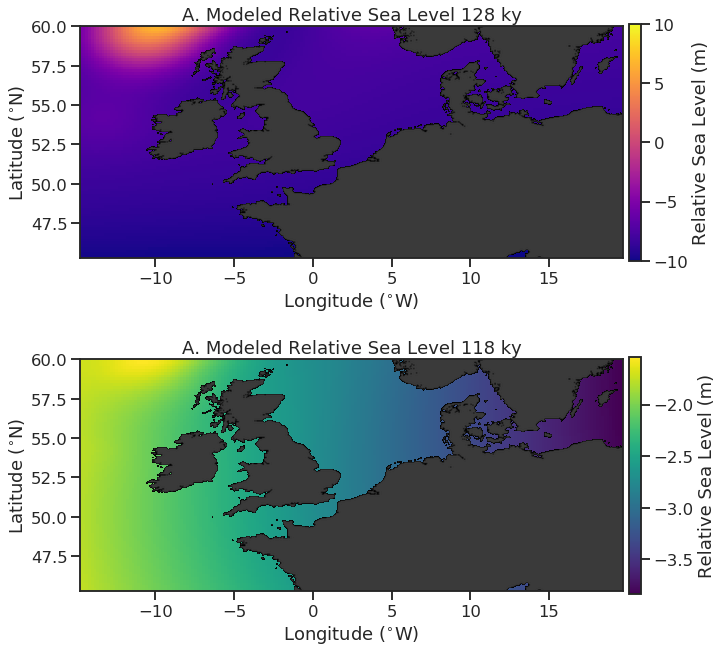

In [59]:
fig = plt.figure(figsize=(10, 9))
plt.subplot(2, 1, 1)
shrink = 0.9
plt.imshow(
    early_LIG,
    interpolation="nearest",
    cmap="plasma",
    extent=model_dims,
    vmin=-10,vmax=10
)
plt.colorbar(
    shrink=shrink,
    pad=0.01,
    label="Relative Sea Level (m)",
)
my_grey = cm.Greys_r
my_grey.set_under("k", alpha=0)
plt.imshow(
    landzoom,
    interpolation="gaussian",
    cmap=my_grey,
    vmin=0.1,
    vmax=5,
    extent=imarray_ext,
)
plt.gca().set_title("A. Modeled Relative Sea Level 128 ky")
plt.gca().grid(False)
plt.gca().set_xlim([model_dims[0], model_dims[1]])
plt.gca().set_ylim([model_dims[2], model_dims[3]])
plt.gca().set_ylabel("Latitude ($^{\circ}$N)")
plt.gca().set_xlabel("Longitude ($^{\circ}$W)")
plt.subplot(2, 1, 2)
plt.imshow(
    late_LIG,
    interpolation="nearest",
    cmap="viridis",
    extent=model_dims,
)
plt.colorbar(
    shrink=shrink,
    pad=0.01,
    label="Relative Sea Level (m)",)
my_grey = cm.Greys_r
my_grey.set_under("k", alpha=0)
plt.imshow(
    landzoom,
    interpolation="gaussian",
    cmap=my_grey,
    vmin=0.1,
    vmax=5,
    extent=imarray_ext,
)
plt.gca().set_title("A. Modeled Relative Sea Level 118 ky")
plt.gca().grid(False)
plt.gca().set_xlim([model_dims[0], model_dims[1]])
plt.gca().set_ylim([model_dims[2], model_dims[3]])
plt.gca().set_ylabel("Latitude ($^{\circ}$N)")
plt.gca().set_xlabel("Longitude ($^{\circ}$W)")
fig.tight_layout(pad=0, w_pad=-2, h_pad=1)


Self reminder for interpretation: subsidence = bottom panel minus the top panel. For example, the orth west corner is -2 at 118 ky and +10 at 128 ky. This area has subsided -12 meters (or uplifted 12 meters). 

## Generate 'data' from true GIA model (varying age and location).

In [60]:
df=pd.read_excel(data_dir/'NWEuropeDatabase_v4.xlsx',header=1)

In [78]:
filtered = df[df['Indicative \nRange'] != '(limiting)']
data = {}
data["lon"] = filtered['Longitude'].dropna().values
data["lat"] = filtered['Latitude'].dropna().values
data["age"] = filtered['Age\n(ka BP)'].dropna().values
data["age_uncertainty"] = filtered['Age Error\n(1σ ka)'].dropna().values
data["REAL_elevation"] = filtered['Relative Sea \nLevel (m)'].dropna().values
data["elevation_uncertainty"] = filtered['RSL Error \n(1σ m)'].dropna().values

GIA_MODEL = models[true_choice]
if "_S" in model_names[true_choice]:
    ESL_CURVE = np.copy(Wael)
if "_T" in model_names[true_choice]:
    ESL_CURVE = np.copy(Wael_T)

z_functions = interpolation_functions(data["lat"], data["lon"], GIA_MODEL, ESL_CURVE, Age_ESL)
Es = []
for i in range(len(z_functions)):
    Es.append(z_functions[i](data['age'][i]))
data["rsl"] = np.array(Es)

Make GMSL during LIG greater than zero and changing:

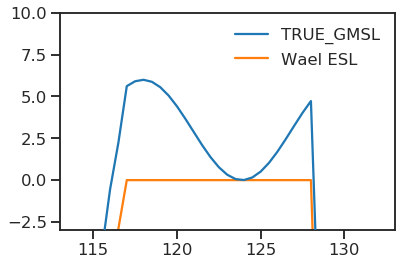

In [79]:
sns.set_context('talk')
LIG = (Age_ESL>=115) & (Age_ESL<=130) 

k=true_choice
GIA_MODEL = models[k]
if '_S' in model_names[k]:
    ESL_CURVE = Wael
if '_T' in model_names[k]:
    ESL_CURVE = Wael_T
    
synth_gmsl = np.copy(ESL_CURVE)
xt=Age_ESL[LIG]-Age_ESL[LIG].min()
synth_gmsl[LIG]=ESL_CURVE[LIG]+3*np.sin(xt/(.6*np.pi))+3
plt.plot(Age_ESL,synth_gmsl,label='TRUE_GMSL',zorder=3)
plt.plot(Age_ESL,ESL_CURVE,label='Wael ESL')
plt.gca().set_xlim([113,133])
plt.gca().set_ylim([-3,10])
plt.legend(loc='best',frameon=False)

In [80]:
synth_gmsl_fun=interp1d(Age_ESL,synth_gmsl)
ESL_CURVE_fun=interp1d(Age_ESL,ESL_CURVE)
synth_gmsl_fun(Age_ESL)

## add true gmsl to RSL model
data['elevation']=np.copy(data['rsl'])
for i in range(data["lat"].size):
    data["elevation"][i] += synth_gmsl_fun(data['age'][i])-ESL_CURVE_fun(data['age'][i])

Look at data:

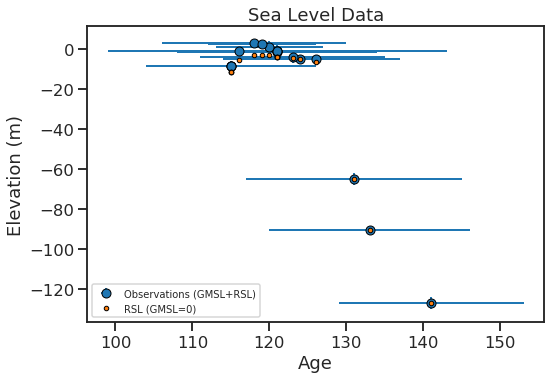

In [91]:
sns.set_context("talk")
fig = plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.errorbar(
    data["age"],
    data["elevation"],
    xerr=data["age_uncertainty"],
    yerr=data["elevation_uncertainty"],
    linestyle="none",
    label="Observations (GMSL+RSL)",
    marker='o',mec='k',lw=2
)
plt.errorbar(
    data["age"],
    data["rsl"],
    linestyle="none",
    label="RSL (GMSL=0)",
    marker='.',mec='k'
)

plt.legend(loc="lower left", frameon=True,fontsize=10)


plt.gca().set_xlabel("Age")
plt.gca().set_ylabel("Elevation (m)")
_ = plt.gca().set_title("Sea Level Data")
# plt.gca().set_xlim([113, 133])


fig.tight_layout()

## MAY WANT TO REMOVE SAMPLES PRE 128 WHERE GIA/RSL BASICALLY EQUALS THE ESL CURVE

In [ ]:
N = data["elevation"].size
comparison = {}
stats_models = {}
gps = {}

for k in range(len(model_names)):
    clear_output(wait=True)
    print("running simulation number " + str(k + 1) + " of " + str(len(models)))
    print("running model: " + model_names[k])
    GIA_MODEL = models[k]
    if "_S" in model_names[k]:
        ESL_CURVE = np.copy(Wael)
    if "_T" in model_names[k]:
        ESL_CURVE = np.copy(Wael_T)

    z_functions = interpolation_functions(
        data["lat"], data["lon"], GIA_MODEL, ESL_CURVE, Age_ESL
    )
    az_trace, trace, model, gp = inference_model(data, z_functions)
    comparison[model_names[k]] = az_trace
    stats_models[model_names[k]] = model
    gps[model_names[k]] = gp
     

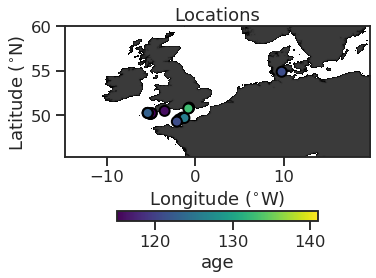

In [93]:
plt.imshow(
    landzoom,
    interpolation="gaussian",
    cmap=my_grey,
    vmin=0.1,
    vmax=5,
    extent=imarray_ext,
)
plt.scatter(data['lon'],data['lat'],c=data['age'],cmap='viridis',s=100,edgecolor='k',lw=2)
plt.colorbar(label='age',shrink=.6,pad=0.25, orientation="horizontal")
plt.gca().set_title("Locations")
plt.gca().grid(False)
plt.gca().set_xlim([model_dims[0], model_dims[1]])
plt.gca().set_ylim([model_dims[2], model_dims[3]])
plt.gca().set_ylabel("Latitude ($^{\circ}$N)")
plt.gca().set_xlabel("Longitude ($^{\circ}$W)")
fig.tight_layout()

## Infer GMSL

In [94]:
N = data["elevation"].size
comparison = {}
stats_models = {}
gps = {}

for k in range(len(model_names)):
    clear_output(wait=True)
    print("running simulation number " + str(k + 1) + " of " + str(len(models)))
    print("running model: " + model_names[k])
    GIA_MODEL = models[k]
    if "_S" in model_names[k]:
        ESL_CURVE = np.copy(Wael)
    if "_T" in model_names[k]:
        ESL_CURVE = np.copy(Wael_T)

    z_functions = interpolation_functions(
        data["lat"], data["lon"], GIA_MODEL, ESL_CURVE, Age_ESL
    )
    az_trace, trace, model, gp = inference_model(data, z_functions)
    comparison[model_names[k]] = az_trace
    stats_models[model_names[k]] = model
    gps[model_names[k]] = gp
     

running simulation number 216 of 216
running model: output96Cp57_Lambeck_Wael_T


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_gmsl, matern_var, matern_ls, age_sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


## Calculate relative model weights for all inferences 
We use leave-one-out (loo) cross validation with an Akaike-type weighting. The weights are stabilized using a Bayesian bootstrap. https://arviz-devs.github.io/arviz/generated/arviz.compare.html

In [95]:
comp = pm.compare(comparison, ic="loo", b_samples=100000) #overkill on samples, but it is fast enough

### Add GIA model parameters and identify TRUE model in Dataframe

In [96]:
compare_model_names = comp.index.values
model_params_df = {}
for i in range(len(compare_model_names)):
    md_id = np.where(model_names == compare_model_names[i])[0][0]
    ice_history = compare_model_names[i].split("_")[1]
    esl_curve = compare_model_names[i].split("_")[2]
    deglacial_rate = compare_model_names[i].split("_")[3]
    model_params_df[compare_model_names[i]] = [
        lower[md_id],
        upper[md_id],
        litho[md_id],
        ice_history,
        esl_curve,
        deglacial_rate,
    ]

df2 = pd.DataFrame.from_dict(
    model_params_df,
    orient="index",
    columns=["LMV", "UMV", "lithosphere", "ice_history", "esl_curve", "deglacial_rate"],
)

comp3 = comp.join(df2)

identify = {}
for i in range(len(model_names)):
    if i == true_choice:
        identify[model_names[i]] = True
    else:
        identify[model_names[i]] = False

df3 = pd.DataFrame.from_dict(identify, orient="index", columns=["true_model"],)

comp3 = comp.join(df2).join(df3)


### Save dataframe as csv

In [97]:
comp3.to_csv('true_model_experiment2.csv')

## Summary figure showing model weightings for all 216 GIA models

In [98]:
# one subplot for each experiment
experiments = [
    ["Lambeck", "S", 96],
    ["Colleoni", "S", 96],
    ["ICE6G", "S", 96],
    ["Lambeck", "T", 96],
    ["Colleoni", "T", 96],
    ["ICE6G", "T", 96],
    ["Lambeck", "S", 71],
    ["Colleoni", "S", 71],
    ["ICE6G", "S", 71],
    ["Lambeck", "T", 71],
    ["Colleoni", "T", 71],
    ["ICE6G", "T", 71],
    ["Lambeck", "S", 48],
    ["Colleoni", "S", 48],
    ["ICE6G", "S", 48],
    ["Lambeck", "T", 48],
    ["Colleoni", "T", 48],
    ["ICE6G", "T", 48],
]

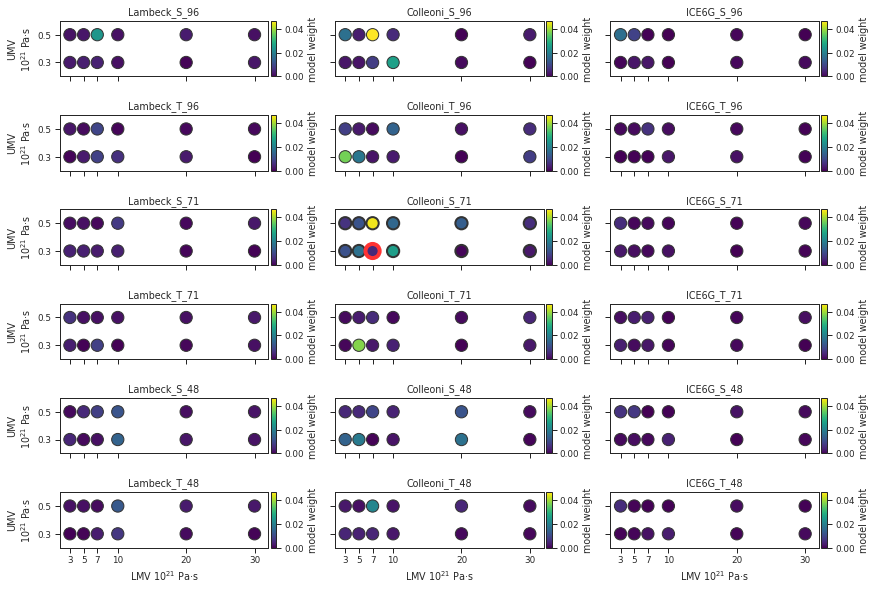

In [99]:
sns.set_context("paper")
fig = plt.figure(figsize=(12, 8))
for i in range(0, 18):
    experiment = experiments[i]
    plt.subplot(6, 3, 1 + i)
    filtered = comp3[
        (comp3.ice_history == experiment[0])
        & (comp3.deglacial_rate == experiment[1])
        & (comp3.lithosphere == experiment[2])
    ]
    if filtered["true_model"].unique().size == 1:
        plt.scatter(
            filtered["LMV"].values,
            filtered["UMV"] / 1e21,
            c=filtered["weight"],
            s=150,
            cmap="viridis",
            edgecolor=(0.2, 0.2, 0.2),
            lw=1,
            vmin=0,
            vmax=comp3["weight"].max(),
            zorder=2,
        )
    else:
        ec = np.dot(
            filtered["true_model"].values.astype(int)[:, np.newaxis],
            np.array([0.8, 0.0, 0.0])[np.newaxis, :],
        )
        ew = filtered["true_model"].values.astype(int) * 2
        s = filtered["true_model"].values.astype(int) * 50
        plt.scatter(
            filtered["LMV"].values,
            filtered["UMV"] / 1e21,
            c=filtered["weight"],
            s=150 + s,
            cmap="viridis",
            edgecolor=np.array([0.2, 0.2, 0.2]) + ec,
            lw=2 + ew,
            vmin=0,
            vmax=comp3["weight"].max(),
            zorder=2,
        )

    plt.colorbar(label="model weight", pad=.01, aspect=10)

    plt.gca().set_xticklabels((np.round(np.unique(lower), 0) / 1e21).astype(int))
    plt.gca().set_yticks(np.unique(upper) / 1e21)
    plt.gca().set_xticks(np.unique(lower))
    plt.gca().set_xlim(1.5e21, 32e21)
    plt.gca().set_ylim(0.2, 0.6)
    if i > 14:
        plt.gca().set_xlabel("LMV $10^{21}$ Pa·s")
    else:
        plt.gca().set_xticklabels([])
    if i % 3 == 0:
        plt.gca().set_ylabel("UMV\n$10^{21}$ Pa·s")
    else:
        plt.gca().set_yticklabels([])

    plt.minorticks_off()
    plt.gca().set_title(experiment[0] + "_" + experiment[1] + "_" + str(experiment[2]))


fig.tight_layout()
fig.tight_layout(pad=0, w_pad=1, h_pad=2)

Each circle represents a GIA model. The color of the circle is the probability that the observations were generated by the model relative to the probability that the observations were generated by any of the other models (the weightings sum to 1). The circle highlighted with a <span style='color:red;font-weight:bold'>RED</span> border is the model that was actually used to generate the data (the 'TRUE' GIA model). Remember that these weightings show similarities between GIA models at the lat/lon, the age of the samples, AND the prescribed GMSL.

## Use the weightings to make a combined GMSL inference
We will never know the 'true' GIA model, but we should include the uncertainty of all of the likely models in our prediction. The weightings offer guidance on how important each model should be in that final inference.

### Generate predictions from gaussian process posterior for top models

In [100]:
# all models with more than 1% weight
top_models = comp3[comp["weight"] > 0.01]["rank"].values
# new timespan to evaluate the gaussian process
X_new = np.linspace(110, 140, 200)[:, np.newaxis]

pred_traces = []  # list to collect all of the predictions
for i in top_models:
    clear_output(wait=True)
    print("sampling model " + str(i + 1) + " of " + str(len(top_models)))
    to_plot = comp3[comp3["rank"] == i].index[0]  # model name (str)
    model = stats_models[to_plot]  # (str) names are used as keys
    gp = gps[to_plot]
    az_trace = comparison[to_plot]

    with model:  # pymc3 model context
        # add conditional to each model (comment out if running this cell twice)
        f_pred = gp.conditional("f_pred", X_new)

    X_new = np.linspace(110, 140, 200)[:, np.newaxis]
    pred_samples = pm.sample_posterior_predictive(
        az_trace.posterior,  # if using pymc3 trace remove '.posterior'
        model=model,
        vars=[f_pred],
        samples=1000,
    )
    pred_traces.append(pred_samples)

sampling model 24 of 24


Add true model inference to the set if its weight was less than 1%

In [107]:
true_model_prediction_index = np.where(comp3.index==model_names[true_choice])[0][0]
if comp3['weight'][true_model_prediction_index]<0.1:
    to_plot = model_names[true_choice]  # model name (str)
    model = stats_models[to_plot]  # (str) names are used as keys
    gp = gps[to_plot]
    az_trace = comparison[to_plot]

    with model:  # pymc3 model context
        # add conditional to each model (comment out if running this cell twice)
        f_pred = gp.conditional("f_pred", X_new)

    X_new = np.linspace(110, 140, 200)[:, np.newaxis]
    pred_samples = pm.sample_posterior_predictive(
        az_trace.posterior,  # if using pymc3 trace remove '.posterior'
        model=model,
        vars=[f_pred],
        samples=1000,
    )
    pred_traces.append(pred_samples)
    

### Generate a weighted prediction

In [111]:
weights = comp['weight'].values[top_models.astype(int)]
weighted_gmsl_trace = weighted_trace(pred_traces[:weights.size], weights)

### Plot predictions from the TRUE GIA model and the weighted metamodel

Text(0.5, 1.0, 'EU GMSL Inference Experiment')

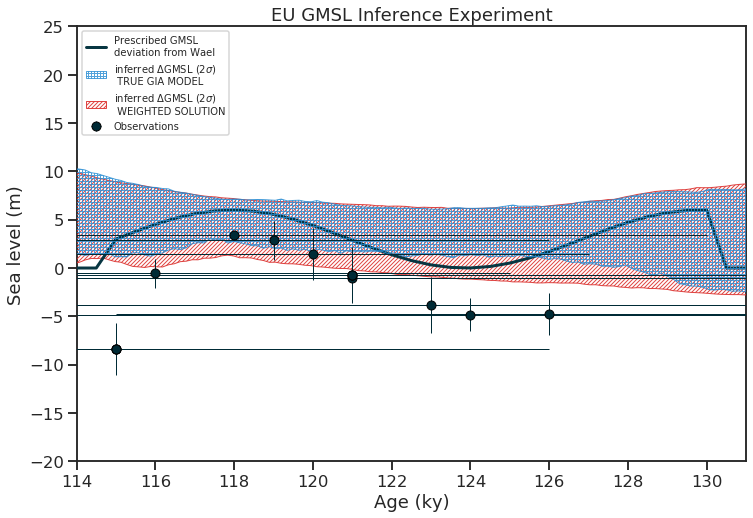

In [141]:
fig = plt.figure(figsize=(12, 8))
sns.set_context("talk")

GIA_MODEL = models[true_choice]
if "_S" in model_names[true_choice]:
    ESL_CURVE = np.copy(Wael)
if "_T" in model_names[true_choice]:
    ESL_CURVE = np.copy(Wael_T)
        
plt.plot(
    Age_ESL,
    synth_gmsl-ESL_CURVE,
    label="Prescribed GMSL\ndeviation from Wael",
    zorder=3,
    lw=3,
    color="#073642",
)



plt.errorbar(
    data["age"],
    data["elevation"],
    xerr=data["age_uncertainty"],
    yerr=data["elevation_uncertainty"],
    marker="o",
    linestyle="none",
    label="Observations",
    color="#002b36",
    zorder=10,lw=1,mec='k'
)


index_of_prediction_from_true = np.where(comp3.index==model_names[true_choice])[0][0]
try: 
    pred_samples = pred_traces[index_of_prediction_from_true]  
except IndexError:
    pred_samples = pred_traces[-1]  
bot = np.percentile(np.array(pred_samples["f_pred"]), 2.5, axis=0)
top = np.percentile(np.array(pred_samples["f_pred"]), 97.5, axis=0)
mean = np.mean(np.array(pred_samples["f_pred"]), axis=0)

plt.gca().fill_between(
    X_new.ravel(),
    bot,
    top,
    fc="none",
    zorder=4,
    alpha=.8,
    label="inferred $\Delta$GMSL (2$\sigma$)\n TRUE GIA MODEL",
    lw=1,
    ec="#268bd2",
    aa=True,
    capstyle="round",
    hatch=r"++++",
)


bot = np.percentile(weighted_gmsl_trace, 2.5, axis=0)
top = np.percentile(weighted_gmsl_trace, 97.5, axis=0)
mean = np.mean(weighted_gmsl_trace, axis=0)

plt.gca().fill_between(
    X_new.ravel(),
    bot,
    top,
    fc="none",
    zorder=3,
    alpha=.9,
    label="inferred $\Delta$GMSL (2$\sigma$)\n WEIGHTED SOLUTION",
    lw=1,
    ec="#dc322f",
    aa=True,
    capstyle="round",
    hatch="//////",
)

plt.gca().set_xlim(LIG_END-3, LIG_START+3)
plt.gca().set_ylim(-20, 25)
plt.legend(loc="upper left", frameon=True, fontsize=10)
plt.gca().set_xlabel("Age (ky)")
plt.gca().set_ylabel("Sea level (m)")
plt.gca().set_title("EU GMSL Inference Experiment")

# Experiment 3: Can we find the true GIA model using data locations, age, and small age errors?
* Select a GIA model to be TRUE
* Generate 'data' from that TRUE GIA model <span style='font-weight:bold;color:red'>Using LAT/LON, RSL error, ages,</span> <span style='font-weight:bold;color:green'><strike>and age errors from real dataset</strike> small age errors</span>
* <span style='font-weight:bold;color:green;text-decoration:line-through'>Add sinusoidal GMSL to the data</span>
* Plug each GIA model into our existing GMSL inference framework
* Compare the weights or information criteria of each model (does the TRUE model win?)
* Use model weightings to make a GMSL inference with ALL models

## True GIA Model:
Select one of the real GIA models as 'True'

In [7]:
np.random.seed(42)

N = len(model_names)
true_choice = np.random.choice(N, 1)[0]
true_model = models[true_choice]
print("Model " + str(model_names[true_choice]) + " selected as TRUE model.")

np.random.seed()

Model output71Cp37_Colleoni_Wael_S selected as TRUE model.


In [8]:
zoomlevel = 4
i = 13  # age slice
early_LIG = ndimage.zoom(true_model[i], zoomlevel, order=3)
i = 3  # age slice
late_LIG = ndimage.zoom(true_model[i], zoomlevel, order=3)

## Look at TRUE GIA model output

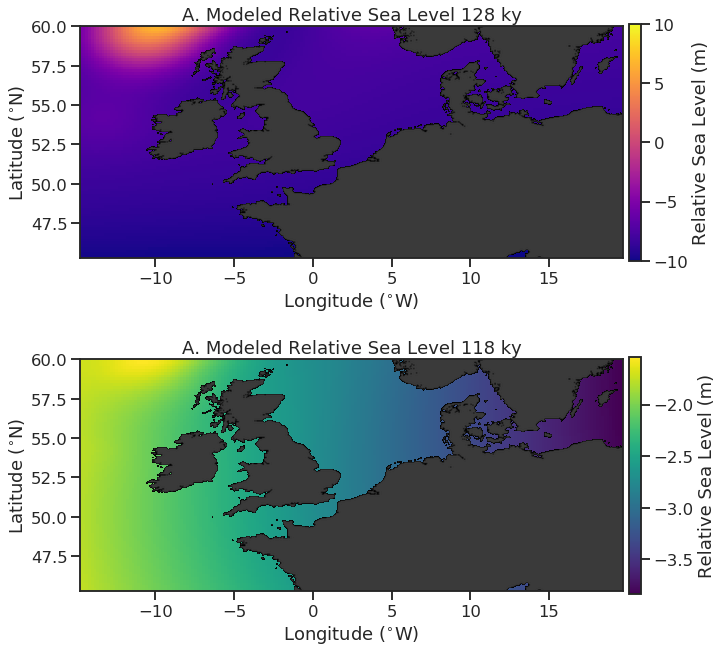

In [9]:
fig = plt.figure(figsize=(10, 9))
plt.subplot(2, 1, 1)
shrink = 0.9
plt.imshow(
    early_LIG,
    interpolation="nearest",
    cmap="plasma",
    extent=model_dims,
    vmin=-10,vmax=10
)
plt.colorbar(
    shrink=shrink,
    pad=0.01,
    label="Relative Sea Level (m)",
)
my_grey = cm.Greys_r
my_grey.set_under("k", alpha=0)
plt.imshow(
    landzoom,
    interpolation="gaussian",
    cmap=my_grey,
    vmin=0.1,
    vmax=5,
    extent=imarray_ext,
)
plt.gca().set_title("A. Modeled Relative Sea Level 128 ky")
plt.gca().grid(False)
plt.gca().set_xlim([model_dims[0], model_dims[1]])
plt.gca().set_ylim([model_dims[2], model_dims[3]])
plt.gca().set_ylabel("Latitude ($^{\circ}$N)")
plt.gca().set_xlabel("Longitude ($^{\circ}$W)")
plt.subplot(2, 1, 2)
plt.imshow(
    late_LIG,
    interpolation="nearest",
    cmap="viridis",
    extent=model_dims,
)
plt.colorbar(
    shrink=shrink,
    pad=0.01,
    label="Relative Sea Level (m)",)
my_grey = cm.Greys_r
my_grey.set_under("k", alpha=0)
plt.imshow(
    landzoom,
    interpolation="gaussian",
    cmap=my_grey,
    vmin=0.1,
    vmax=5,
    extent=imarray_ext,
)
plt.gca().set_title("A. Modeled Relative Sea Level 118 ky")
plt.gca().grid(False)
plt.gca().set_xlim([model_dims[0], model_dims[1]])
plt.gca().set_ylim([model_dims[2], model_dims[3]])
plt.gca().set_ylabel("Latitude ($^{\circ}$N)")
plt.gca().set_xlabel("Longitude ($^{\circ}$W)")
fig.tight_layout(pad=0, w_pad=-2, h_pad=1)


Self reminder for interpretation: subsidence = bottom panel minus the top panel. For example, the north west corner is -2 at 118 ky and +10 at 128 ky. This area has subsided -12 meters (or uplifted 12 meters). 

## Generate 'data' from true GIA model (varying age and location).

In [10]:
df=pd.read_excel(data_dir/'NWEuropeDatabase_v4.xlsx',header=1)

In [12]:
filtered = df[df['Indicative \nRange'] != '(limiting)']
data = {}
data["lon"] = filtered['Longitude'].dropna().values
data["lat"] = filtered['Latitude'].dropna().values
data["age"] = filtered['Age\n(ka BP)'].dropna().values
data["age_uncertainty"] = np.ones(data['lon'].size)*.5
data["REAL_elevation"] = filtered['Relative Sea \nLevel (m)'].dropna().values
data["elevation_uncertainty"] = filtered['RSL Error \n(1σ m)'].dropna().values

GIA_MODEL = models[true_choice]
if "_S" in model_names[true_choice]:
    ESL_CURVE = np.copy(Wael)
if "_T" in model_names[true_choice]:
    ESL_CURVE = np.copy(Wael_T)

z_functions = interpolation_functions(data["lat"], data["lon"], GIA_MODEL, ESL_CURVE, Age_ESL)
Es = []
for i in range(len(z_functions)):
    Es.append(z_functions[i](data['age'][i]))
data["rsl"] = np.array(Es)

No added GMSL to the data in this experiment

In [14]:
# sns.set_context('talk')
# LIG = (Age_ESL>=115) & (Age_ESL<=130) 

# k=true_choice
# GIA_MODEL = models[k]
# if '_S' in model_names[k]:
#     ESL_CURVE = Wael
# if '_T' in model_names[k]:
#     ESL_CURVE = Wael_T
    
# synth_gmsl = np.copy(ESL_CURVE)
# xt=Age_ESL[LIG]-Age_ESL[LIG].min()
# synth_gmsl[LIG]=ESL_CURVE[LIG]+3*np.sin(xt/(.6*np.pi))+3
# plt.plot(Age_ESL,synth_gmsl,label='TRUE_GMSL',zorder=3)
# plt.plot(Age_ESL,ESL_CURVE,label='Wael ESL')
# plt.gca().set_xlim([113,133])
# plt.gca().set_ylim([-3,10])
# plt.legend(loc='best',frameon=False)

In [15]:
# synth_gmsl_fun=interp1d(Age_ESL,synth_gmsl)
# ESL_CURVE_fun=interp1d(Age_ESL,ESL_CURVE)
# synth_gmsl_fun(Age_ESL)

## add true gmsl to RSL model
data['elevation']=np.copy(data['rsl'])
# for i in range(data["lat"].size):
#     data["elevation"][i] += synth_gmsl_fun(data['age'][i])-ESL_CURVE_fun(data['age'][i])

Look at data:

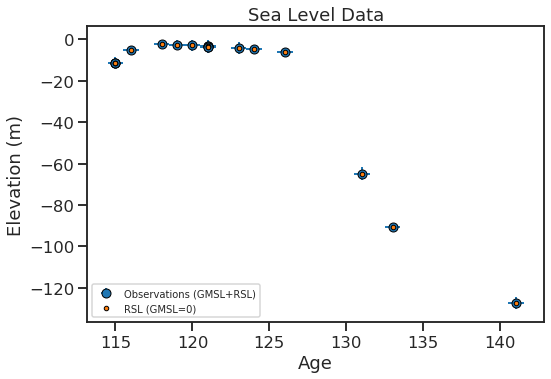

In [16]:
sns.set_context("talk")
fig = plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.errorbar(
    data["age"],
    data["elevation"],
    xerr=data["age_uncertainty"],
    yerr=data["elevation_uncertainty"],
    linestyle="none",
    label="Observations (GMSL+RSL)",
    marker='o',mec='k',lw=2
)
plt.errorbar(
    data["age"],
    data["rsl"],
    linestyle="none",
    label="RSL (GMSL=0)",
    marker='.',mec='k'
)

plt.legend(loc="lower left", frameon=True,fontsize=10)


plt.gca().set_xlabel("Age")
plt.gca().set_ylabel("Elevation (m)")
_ = plt.gca().set_title("Sea Level Data")
# plt.gca().set_xlim([113, 133])


fig.tight_layout()

## MAY WANT TO REMOVE SAMPLES PRE 128 WHERE GIA/RSL BASICALLY EQUALS THE ESL CURVE

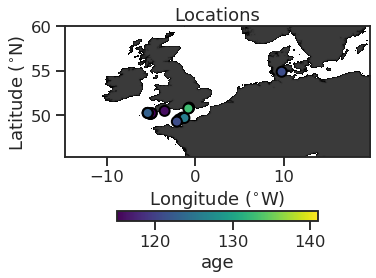

In [18]:
plt.imshow(
    landzoom,
    interpolation="gaussian",
    cmap=my_grey,
    vmin=0.1,
    vmax=5,
    extent=imarray_ext,
)
plt.scatter(data['lon'],data['lat'],c=data['age'],cmap='viridis',s=100,edgecolor='k',lw=2)
plt.colorbar(label='age',shrink=.6,pad=0.25, orientation="horizontal")
plt.gca().set_title("Locations")
plt.gca().grid(False)
plt.gca().set_xlim([model_dims[0], model_dims[1]])
plt.gca().set_ylim([model_dims[2], model_dims[3]])
plt.gca().set_ylabel("Latitude ($^{\circ}$N)")
plt.gca().set_xlabel("Longitude ($^{\circ}$W)")
fig.tight_layout()

## Infer GMSL

In [19]:
N = data["elevation"].size
comparison = {}
stats_models = {}
gps = {}

for k in range(len(model_names)):
    clear_output(wait=True)
    print("running simulation number " + str(k + 1) + " of " + str(len(models)))
    print("running model: " + model_names[k])
    GIA_MODEL = models[k]
    if "_S" in model_names[k]:
        ESL_CURVE = np.copy(Wael)
    if "_T" in model_names[k]:
        ESL_CURVE = np.copy(Wael_T)

    z_functions = interpolation_functions(
        data["lat"], data["lon"], GIA_MODEL, ESL_CURVE, Age_ESL
    )
    az_trace, trace, model, gp = inference_model(data, z_functions)
    comparison[model_names[k]] = az_trace
    stats_models[model_names[k]] = model
    gps[model_names[k]] = gp
     

running simulation number 216 of 216
running model: output96Cp57_Lambeck_Wael_T


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observed_elevation_u, sigma, m_gmsl, matern_var, matern_ls, age_sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 701 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.21468018418338117, but should be close to 0.8. Try to increase the number of tuning steps.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7107402822073848, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


## Calculate relative model weights for all inferences 
We use leave-one-out (loo) cross validation with an Akaike-type weighting. The weights are stabilized using a Bayesian bootstrap. https://arviz-devs.github.io/arviz/generated/arviz.compare.html

In [20]:
comp = pm.compare(comparison, ic="loo", b_samples=100000) #overkill on samples, but it is fast enough

### Add GIA model parameters and identify TRUE model in Dataframe

In [22]:
compare_model_names = comp.index.values
model_params_df = {}
for i in range(len(compare_model_names)):
    md_id = np.where(model_names == compare_model_names[i])[0][0]
    ice_history = compare_model_names[i].split("_")[1]
    esl_curve = compare_model_names[i].split("_")[2]
    deglacial_rate = compare_model_names[i].split("_")[3]
    model_params_df[compare_model_names[i]] = [
        lower[md_id],
        upper[md_id],
        litho[md_id],
        ice_history,
        esl_curve,
        deglacial_rate,
    ]

df2 = pd.DataFrame.from_dict(
    model_params_df,
    orient="index",
    columns=["LMV", "UMV", "lithosphere", "ice_history", "esl_curve", "deglacial_rate"],
)

comp3 = comp.join(df2)

identify = {}
for i in range(len(model_names)):
    if i == true_choice:
        identify[model_names[i]] = True
    else:
        identify[model_names[i]] = False

df3 = pd.DataFrame.from_dict(identify, orient="index", columns=["true_model"],)

comp3 = comp.join(df2).join(df3)


### Save dataframe as csv

In [23]:
comp3.to_csv('true_model_experiment3.csv')

## Summary figure showing model weightings for all 216 GIA models

In [24]:
# one subplot for each experiment
experiments = [
    ["Lambeck", "S", 96],
    ["Colleoni", "S", 96],
    ["ICE6G", "S", 96],
    ["Lambeck", "T", 96],
    ["Colleoni", "T", 96],
    ["ICE6G", "T", 96],
    ["Lambeck", "S", 71],
    ["Colleoni", "S", 71],
    ["ICE6G", "S", 71],
    ["Lambeck", "T", 71],
    ["Colleoni", "T", 71],
    ["ICE6G", "T", 71],
    ["Lambeck", "S", 48],
    ["Colleoni", "S", 48],
    ["ICE6G", "S", 48],
    ["Lambeck", "T", 48],
    ["Colleoni", "T", 48],
    ["ICE6G", "T", 48],
]

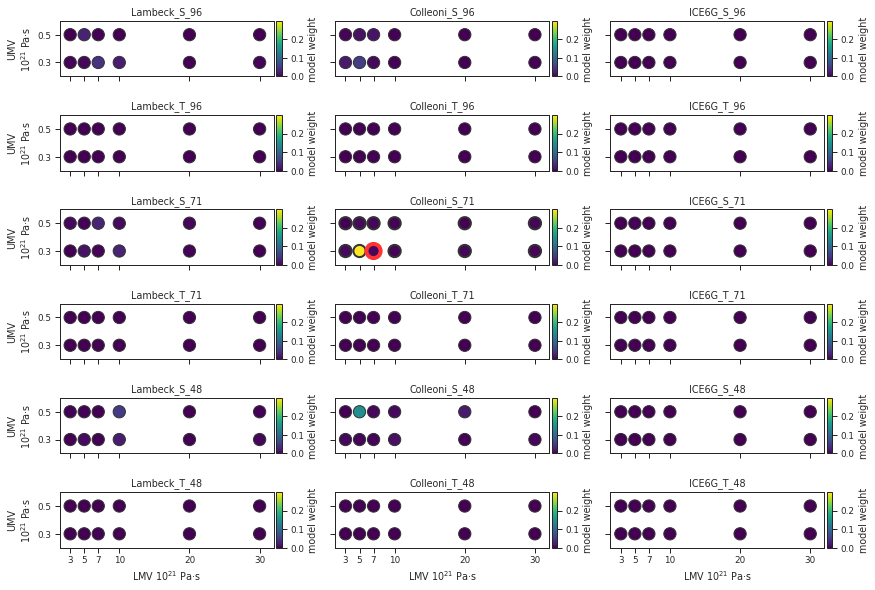

In [25]:
sns.set_context("paper")
fig = plt.figure(figsize=(12, 8))
for i in range(0, 18):
    experiment = experiments[i]
    plt.subplot(6, 3, 1 + i)
    filtered = comp3[
        (comp3.ice_history == experiment[0])
        & (comp3.deglacial_rate == experiment[1])
        & (comp3.lithosphere == experiment[2])
    ]
    if filtered["true_model"].unique().size == 1:
        plt.scatter(
            filtered["LMV"].values,
            filtered["UMV"] / 1e21,
            c=filtered["weight"],
            s=150,
            cmap="viridis",
            edgecolor=(0.2, 0.2, 0.2),
            lw=1,
            vmin=0,
            vmax=comp3["weight"].max(),
            zorder=2,
        )
    else:
        ec = np.dot(
            filtered["true_model"].values.astype(int)[:, np.newaxis],
            np.array([0.8, 0.0, 0.0])[np.newaxis, :],
        )
        ew = filtered["true_model"].values.astype(int) * 2
        s = filtered["true_model"].values.astype(int) * 50
        plt.scatter(
            filtered["LMV"].values,
            filtered["UMV"] / 1e21,
            c=filtered["weight"],
            s=150 + s,
            cmap="viridis",
            edgecolor=np.array([0.2, 0.2, 0.2]) + ec,
            lw=2 + ew,
            vmin=0,
            vmax=comp3["weight"].max(),
            zorder=2,
        )

    plt.colorbar(label="model weight", pad=.01, aspect=10)

    plt.gca().set_xticklabels((np.round(np.unique(lower), 0) / 1e21).astype(int))
    plt.gca().set_yticks(np.unique(upper) / 1e21)
    plt.gca().set_xticks(np.unique(lower))
    plt.gca().set_xlim(1.5e21, 32e21)
    plt.gca().set_ylim(0.2, 0.6)
    if i > 14:
        plt.gca().set_xlabel("LMV $10^{21}$ Pa·s")
    else:
        plt.gca().set_xticklabels([])
    if i % 3 == 0:
        plt.gca().set_ylabel("UMV\n$10^{21}$ Pa·s")
    else:
        plt.gca().set_yticklabels([])

    plt.minorticks_off()
    plt.gca().set_title(experiment[0] + "_" + experiment[1] + "_" + str(experiment[2]))


fig.tight_layout()
fig.tight_layout(pad=0, w_pad=1, h_pad=2)

Each circle represents a GIA model. The color of the circle is the probability that the observations were generated by the model relative to the probability that the observations were generated by any of the other models (the weightings sum to 1). The circle highlighted with a <span style='color:red;font-weight:bold'>RED</span> border is the model that was actually used to generate the data (the 'TRUE' GIA model). Remember that these weightings show similarities between GIA models at the lat/lon, the age of the samples, AND the prescribed GMSL.

## Use the weightings to make a combined GMSL inference
We will never know the 'true' GIA model, but we should include the uncertainty of all of the likely models in our prediction. The weightings offer guidance on how important each model should be in that final inference.

### Generate predictions from gaussian process posterior for top models

In [26]:
# all models with more than 1% weight
top_models = comp3[comp["weight"] > 0.01]["rank"].values
# new timespan to evaluate the gaussian process
X_new = np.linspace(110, 140, 200)[:, np.newaxis]

pred_traces = []  # list to collect all of the predictions
for i in top_models:
    clear_output(wait=True)
    print("sampling model " + str(i + 1) + " of " + str(len(top_models)))
    to_plot = comp3[comp3["rank"] == i].index[0]  # model name (str)
    model = stats_models[to_plot]  # (str) names are used as keys
    gp = gps[to_plot]
    az_trace = comparison[to_plot]

    with model:  # pymc3 model context
        # add conditional to each model (comment out if running this cell twice)
        f_pred = gp.conditional("f_pred", X_new)

    X_new = np.linspace(110, 140, 200)[:, np.newaxis]
    pred_samples = pm.sample_posterior_predictive(
        az_trace.posterior,  # if using pymc3 trace remove '.posterior'
        model=model,
        vars=[f_pred],
        samples=1000,
    )
    pred_traces.append(pred_samples)

sampling model 16 of 16


Add true model inference to the set if its weight was less than 1%

In [27]:
true_model_prediction_index = np.where(comp3.index==model_names[true_choice])[0][0]
if comp3['weight'][true_model_prediction_index]<0.1:
    to_plot = model_names[true_choice]  # model name (str)
    model = stats_models[to_plot]  # (str) names are used as keys
    gp = gps[to_plot]
    az_trace = comparison[to_plot]

    with model:  # pymc3 model context
        # add conditional to each model (comment out if running this cell twice)
        f_pred = gp.conditional("f_pred", X_new)

    X_new = np.linspace(110, 140, 200)[:, np.newaxis]
    pred_samples = pm.sample_posterior_predictive(
        az_trace.posterior,  # if using pymc3 trace remove '.posterior'
        model=model,
        vars=[f_pred],
        samples=1000,
    )
    pred_traces.append(pred_samples)
    

### Generate a weighted prediction

In [28]:
weights = comp['weight'].values[top_models.astype(int)]
weighted_gmsl_trace = weighted_trace(pred_traces[:weights.size], weights)

### Plot predictions from the TRUE GIA model and the weighted metamodel

Text(0.5, 1.0, 'EU GMSL Inference Experiment')

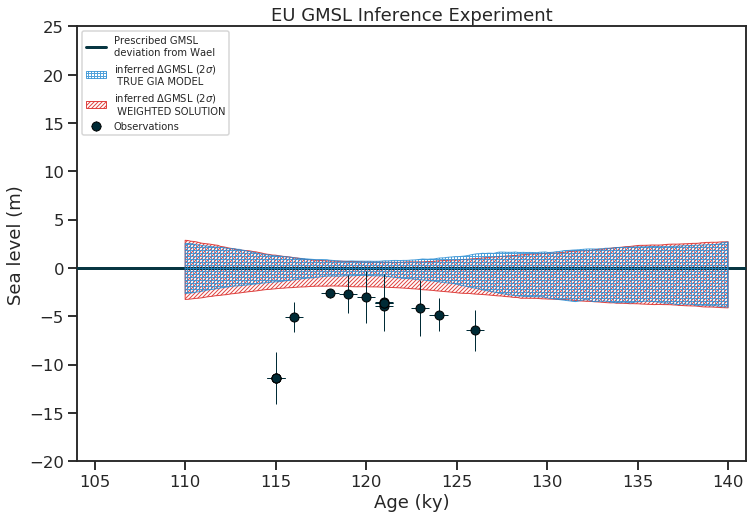

In [87]:
fig = plt.figure(figsize=(12, 8))
sns.set_context("talk")

        
plt.plot(
    Age_ESL,
    np.zeros(Age_ESL.shape),
    label="Prescribed GMSL\ndeviation from Wael",
    zorder=3,
    lw=3,
    color="#073642",
)



plt.errorbar(
    data["age"],
    data["elevation"],
    xerr=data["age_uncertainty"],
    yerr=data["elevation_uncertainty"],
    marker="o",
    linestyle="none",
    label="Observations",
    color="#002b36",
    zorder=10,lw=1,mec='k'
)


index_of_prediction_from_true = np.where(comp3.index==model_names[true_choice])[0][0]
try: 
    pred_samples = pred_traces[index_of_prediction_from_true]  
except IndexError:
    pred_samples = pred_traces[-1]  
bot = np.percentile(np.array(pred_samples["f_pred"]), 2.5, axis=0)
top = np.percentile(np.array(pred_samples["f_pred"]), 97.5, axis=0)
mean = np.mean(np.array(pred_samples["f_pred"]), axis=0)

plt.gca().fill_between(
    X_new.ravel(),
    bot,
    top,
    fc="none",
    zorder=4,
    alpha=.8,
    label="inferred $\Delta$GMSL (2$\sigma$)\n TRUE GIA MODEL",
    lw=1,
    ec="#268bd2",
    aa=True,
    capstyle="round",
    hatch=r"++++",
)


bot = np.percentile(weighted_gmsl_trace, 2.5, axis=0)
top = np.percentile(weighted_gmsl_trace, 97.5, axis=0)
mean = np.mean(weighted_gmsl_trace, axis=0)

plt.gca().fill_between(
    X_new.ravel(),
    bot,
    top,
    fc="none",
    zorder=3,
    alpha=.9,
    label="inferred $\Delta$GMSL (2$\sigma$)\n WEIGHTED SOLUTION",
    lw=1,
    ec="#dc322f",
    aa=True,
    capstyle="round",
    hatch="//////",
)

plt.gca().set_xlim(LIG_END-13, LIG_START+13)
plt.gca().set_ylim(-20, 25)
plt.legend(loc="upper left", frameon=True, fontsize=10)
plt.gca().set_xlabel("Age (ky)")
plt.gca().set_ylabel("Sea level (m)")
plt.gca().set_title("EU GMSL Inference Experiment")

(-8, -2)

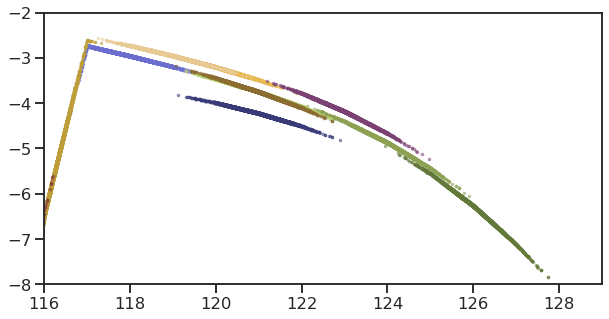

In [86]:
TRC = az_trace.posterior
plt.figure(figsize=(10,5))
sns.set_palette('tab20b')
plt.plot(np.array(TRC['age']).reshape(-1,17),np.array(TRC['GIA']).reshape(-1,17),'.',markersize=5,alpha=.5)
plt.gca().set_xlim(LIG_END-1, LIG_START+1)
plt.gca().set_ylim(-8, -2)

(4000, 17)

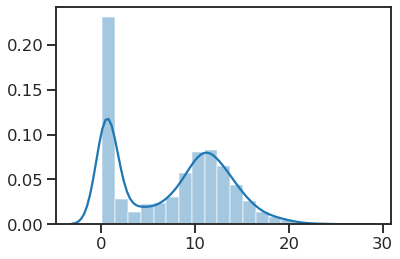

In [38]:
sns.distplot(trace['sigma'])

In [109]:
k=0
print("running model: " + model_names[k])
GIA_MODEL = models[k]
if "_S" in model_names[k]:
    ESL_CURVE = np.copy(Wael)
if "_T" in model_names[k]:
    ESL_CURVE = np.copy(Wael_T)

z_functions = interpolation_functions(
    data["lat"], data["lon"], GIA_MODEL, ESL_CURVE, Age_ESL
)
az_trace, trace, model, gp = inference_model(data, z_functions)


running model: output48Cp310_Colleoni_Wael_S


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observed_elevation_u, sigma, m_gmsl, matern_var, matern_ls, age_sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 236 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4856314448824282, but should be close to 0.8. Try to increase the number of tuning steps.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 171 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6880227775847263, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


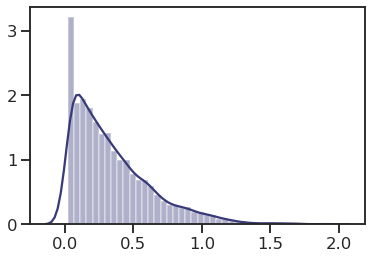

In [115]:
sns.distplot(trace['sigma'])
# sns.kdeplot([pm.HalfCauchy.dist(beta=1).random() for i in range(10000)],clip=[0,20])

In [116]:

with model:  # pymc3 model context
    # add conditional to each model (comment out if running this cell twice)
    f_pred = gp.conditional("f_pred", X_new, pred_noise=True)

X_new = np.linspace(110, 140, 200)[:, np.newaxis]
pred_samples = pm.sample_posterior_predictive(
    az_trace.posterior,  # if using pymc3 trace remove '.posterior'
    model=model,
    vars=[f_pred],
    samples=500,
)


(-20, 25)

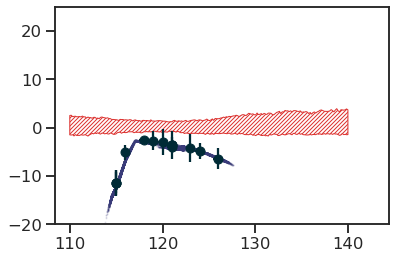

In [119]:
# plt.plot(trace['ages'].ravel(),trace['gmsl_points'].ravel(),'.',markersize=2,alpha=.1)
plt.plot(trace['age'].ravel(),trace['GIA'].ravel(),'.',markersize=2,alpha=.1)

plt.errorbar(
    data["age"],
    data["elevation"],
    xerr=data["age_uncertainty"],
    yerr=data["elevation_uncertainty"],
    marker="o",
    linestyle="none",
    label="Observations",
    color="#002b36",
    zorder=10,
)

bot = np.percentile(pred_samples['f_pred'], 2.5, axis=0)
top = np.percentile(pred_samples['f_pred'], 97.5, axis=0)
mean = np.mean(pred_samples['f_pred'], axis=0)

plt.gca().fill_between(
    X_new.ravel(),
    bot,
    top,
    fc="none",
    zorder=1,
    alpha=1,
    label="inferred $\Delta$GMSL (2$\sigma$)\n WEIGHTED SOLUTION",
    lw=1,
    ec="#dc322f",
    aa=True,
    capstyle="round",
    hatch="//////",
)
plt.gca().set_ylim(-20, 25)